# **Manpower Planning**
## **Using Competency Assessment Method with Gurobi Framework**

_by: TK-Bunga Matahari Team_

---

# **Manpower Planning Objectives and Process**

## *The Objectives*

1. Optimizing the Use of Human Resources
2. Minimizing Recruitment Costs
3. Meeting Future Workforce Needs
4. Maintaining an Adequate Workforce

## *The Process*

1. Determine The Company’s Targets and Goals
	- How does a company optimize the workforce with the initial fund of $10.000?
2. Assess Current Workforce
	- Distribution of employees in these work units
	- Distribution of employees that have high/low skill value
	- Distribution of under-qualified and overqualified employees
3. Forecast Future Needs
	- Workload Analysis
	- Workforce Analysis
	- Trend Analysis
4. Gap Analysis
	- Assessing the current status of current workforce and determining where company want to be in the future


# 0. The Obligatory Part


In [280]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import Model, GRB, quicksum

# 1. Define the Data Structure

## 1.1. Employee and Task Data

In [281]:
# Run this if the data in Local/Repository
new_employee_path = "./data/fixed_data_employee.csv"
new_task_path = "./data/fixed_data_task.csv"

In [282]:
# Read data
employee_skills_df = pd.read_csv(new_employee_path, index_col='No')
# employee_skills_df.drop(columns=['no'], inplace=True, errors='ignore')

employees = employee_skills_df.index.tolist()
skills_name = employee_skills_df.columns[2:].tolist()

employee_skills_df

employee_id            Role  Mathematics.Linear Algebra  \
No                                                            
1      Talent 1  Data Scientist                           1   
2      Talent 2  Data Scientist                           4   
3      Talent 3    Data Analyst                           3   
4      Talent 4  Data Scientist                           3   
5      Talent 5    Data Analyst                           2   
..          ...             ...                         ...   
105  Talent 107    Data Analyst                           1   
106  Talent 108    Data Analyst                           3   
107  Talent 109   Data Engineer                           5   
108  Talent 110  Data Scientist                           3   
109  Talent 112    Data Analyst                           2   

     Mathematics.Differential Equations  Mathematics.Optimization Technique  \
No                                                                            
1                                     1                                   2   
2                                     4                                   4   
3                                     2                                   2   
4                                     2                                   3   
5                                     1                                   3   
..                                  ...                                 ...   
105                                   4                                   4   
106                                   3                                   3   
107                                   5                                   4   
108                                   3                                   3   
109                                   2                                   2   

     Mathematics.Calculus  Mathematics.Combinatorics & Graph  \
No                                                             
1                       1                                  2   
2                       4                                  3   
3                       3                                  2   
4                       2                                  3   
5                       1                                  1   
..                    ...                                ...   
105                     3                                  4   
106                     3                                  4   
107                     5                                  3   
108                     3                                  3   
109                     2                                  2   

     Statistics & Probabilities.Statistics  \
No                                           
1                                        3   
2                                        5   
3                                        3   
4                                        4   
5                                        1   
..                                     ...   
105                                      3   
106                                      2   
107                                      4   
108                                      4   
109                                      2   

     Statistics & Probabilities.Probability & Sampling  \
No                                                       
1                                                    3   
2                                                    4   
3                                                    3   
4                                                    3   
5                                                    2   
..                                                 ...   
105                                                  4   
106                                                  2   
107                                                  4   
108                                                  4   
109                         

In [283]:
skills_name

['Mathematics.Linear Algebra',
 'Mathematics.Differential Equations',
 'Mathematics.Optimization Technique',
 'Mathematics.Calculus',
 'Mathematics.Combinatorics & Graph',
 'Statistics & Probabilities.Statistics',
 'Statistics & Probabilities.Probability & Sampling',
 'Statistics & Probabilities.Bayessian Method',
 'Statistics & Probabilities.Hypothesis Testing',
 'Statistics & Probabilities.A/B Testing',
 'Statistics & Probabilities.CUPED',
 'Data Structures & Algorithms.Complexity Analysis',
 'Data Structures & Algorithms.Programming',
 'Data Structures & Algorithms.Data Structures',
 'Data Structures & Algorithms.Algorithms',
 'Data Structures & Algorithms.Advanced Algorithms',
 'Data Structures & Algorithms.SQL',
 'Data Structures & Algorithms.Shell / Bash Scripting',
 'Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA',
 'Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling',
 'Econometrics, Data Analysis, and Data Visualization.Ec

## 1.2. Optimization Output Data

In [284]:
result_moo = pd.read_csv('./output_VM/3_gap_0.025/result_5_MOO_2.csv')
result_moo.head()

employee       company     assigned_task  sum_sp  wasted_sp  \
0  Talent 1        ['P3']          ['T270']       8         12   
1  Talent 2  ['P3', 'P3']   ['T97', 'T166']      11          9   
2  Talent 3  ['P2', 'P2']  ['T201', 'T297']      11          9   
3  Talent 4  ['P5', 'P5']  ['T153', 'T296']      10         10   
4  Talent 5        ['P4']           ['T39']       8         12   

                                 assessment_score  
0                         [-0.027166504381694268]  
1  [-0.017692307692307688, -0.017582417582417582]  
2   [-0.01773854560739807, -0.011648351648351648]  
3   [-0.01749788672865596, -0.011564986737400529]  
4                         [-0.029608127721335267]

## 1.3. Estimated Salary Data

In [285]:
salary_job_df = pd.read_csv('./data/linreg_salary_job.csv')
salary_job_df.head()

job_role      junior      middle      senior
0  Artificial intelligence  15,359,986  20,517,907  34,001,747
1             Data Analyst  10,361,232  15,519,153  29,002,993
2            Data Engineer  13,996,396  19,154,317  32,638,157
3           Data Scientist  16,557,921  21,715,842  35,199,682

In [286]:
job_roles = salary_job_df['job_role'].unique()
levels = {
    'junior': salary_job_df['junior'],
    'middle': salary_job_df['middle'],
    'senior': salary_job_df['senior']
}
levels

{'junior': 0    15,359,986
 1    10,361,232
 2    13,996,396
 3    16,557,921
 Name: junior, dtype: object,
 'middle': 0    20,517,907
 1    15,519,153
 2    19,154,317
 3    21,715,842
 Name: middle, dtype: object,
 'senior': 0    34,001,747
 1    29,002,993
 2    32,638,157
 3    35,199,682
 Name: senior, dtype: object}

## 1.4. Company Targets

In [287]:
initial_fund = 10000 # USD

# 2. Assess Current Workforce

Using Exploratory Data Analysis (EDA), we can analyze the distribution and the insight of our current data and optimization result

## 2.1. The Distribution by Role
To see how much the employees we have by Role

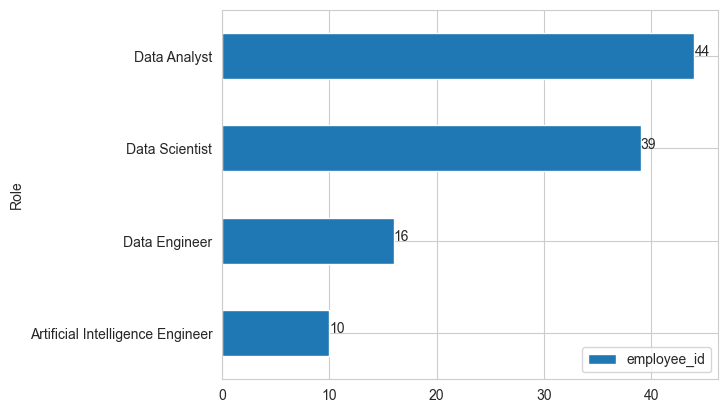

In [288]:
# Plot the horizontal bar chart
ax = employee_skills_df[['Role','employee_id']].groupby('Role', as_index=False).count().sort_values('employee_id',ascending=True)\
.plot(kind='barh', x = 'Role')

# Annotate the values on each bar
for index, value in enumerate(employee_skills_df[['Role','employee_id']].groupby('Role', as_index=False).count().sort_values('employee_id',ascending=True)\
['employee_id']):
    ax.text(value, index, str(value))

plt.show()

## 2.2. The Distribution by Skill Value (3-5)
Value 3-5 can we consider that employees have a good skill in that competency

In [289]:
skills_list = employee_skills_df.drop(['employee_id','Role'], axis=1).columns

In [290]:
for skill in skills_list:
  print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)])/112*100,2)}%""")

Mathematics.Linear Algebra :  71.43%
Mathematics.Differential Equations :  63.39%
Mathematics.Optimization Technique :  63.39%
Mathematics.Calculus :  65.18%
Mathematics.Combinatorics & Graph :  59.82%
Statistics & Probabilities.Statistics :  87.5%
Statistics & Probabilities.Probability & Sampling :  80.36%
Statistics & Probabilities.Bayessian Method :  54.46%
Statistics & Probabilities.Hypothesis Testing :  66.07%
Statistics & Probabilities.A/B Testing :  62.5%
Statistics & Probabilities.CUPED :  46.43%
Data Structures & Algorithms.Complexity Analysis :  66.96%
Data Structures & Algorithms.Programming :  89.29%
Data Structures & Algorithms.Data Structures :  89.29%
Data Structures & Algorithms.Algorithms :  86.61%
Data Structures & Algorithms.Advanced Algorithms :  67.86%
Data Structures & Algorithms.SQL :  96.43%
Data Structures & Algorithms.Shell / Bash Scripting :  71.43%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  94.64%
Econometrics, Data Analy

It is interesting to explore more on certain parts tailored to the role (example: MLOPS - AI, does the percentage of each MLOPS skill match the amount of AI available, or is there a significant difference?)

### 2.2.1. Data Analyst Distribution

The skills mastered by 50% of the population of each role will be explored.

In [291]:
# Data Analyst
print(f"Total Data Analyst percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Data Analyst'])/len(employee_skills_df)*100}%")
for skill in skills_list:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Data Analyst')])/112*100,2) >= (42*0.6):
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Data Analyst')])/112*100,2)}%""")

Total Data Analyst percentage in population: 40.36697247706422%
Statistics & Probabilities.Statistics :  33.93%
Statistics & Probabilities.Probability & Sampling :  27.68%
Statistics & Probabilities.Hypothesis Testing :  25.89%
Data Structures & Algorithms.Programming :  32.14%
Data Structures & Algorithms.Data Structures :  33.93%
Data Structures & Algorithms.Algorithms :  31.25%
Data Structures & Algorithms.SQL :  38.39%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  36.61%
Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling :  35.71%
Econometrics, Data Analysis, and Data Visualization.Regression Analysis :  30.36%
Econometrics, Data Analysis, and Data Visualization.Time Series Analysis :  28.57%
Econometrics, Data Analysis, and Data Visualization.Correlation Analysis :  30.36%
Data & Cloud Engineering.Relational DB :  33.04%


dari skill-skill yang dikuasai oleh kurang lebih 60% Data Analyst:
- Data Analyst menguasai beberapa topic: Statistics & Probabilities (3/6), Data Structures & Algorithms (4/7), Econometrics, Data Analysis, and Data Visualization (5/8), Relational DB.
- Dari topic Statistics & Probabilities, banyak talent kita yang menguasai Statistics, sementara lebih sedikit untuk skill Probability & Sampling dan Hypothesis Testing (mungkin dikarenakan use case di telkom belum mengerjakan A/B Testing)
- Dari topic Data Structures & Algorithms, talent kita sangat menguasai SQL, Data Structures, Programming, dan Algorithms.
- Dari topic Econometrics, Data Analysis, and Data Visualization, talent kita sangat menguasai Data Preprocessing & EDA, Data Viz & Storytelling, Regression Analysis, Time Series Analysis, and Correlation Analysis.
- Dari topic Data & Cloud Engineering, talent kita hanya menguasai Relational DB.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\1224956504.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_da_percentages, shade=True, color='skyblue')


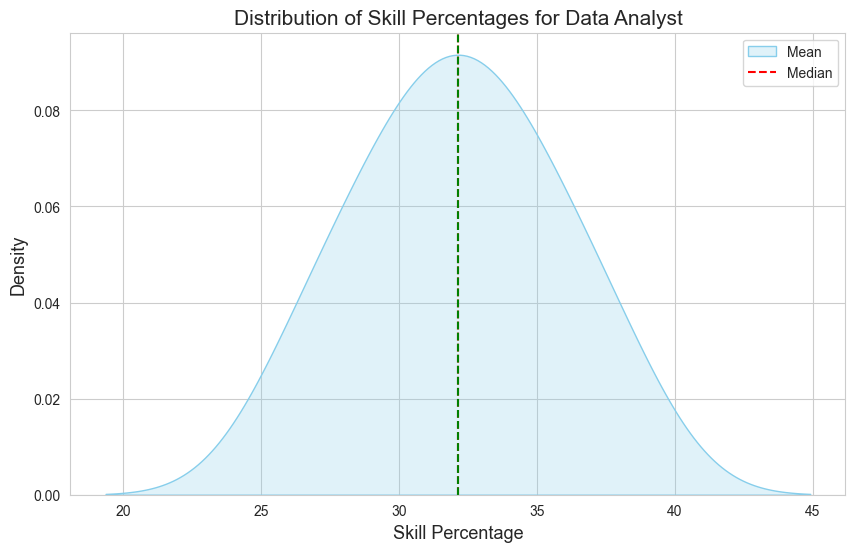

In [292]:
# Create a list to store the percentages of each skill
skill_da_percentages = []

for skill in skills_list:
  skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                   (employee_skills_df['Role']=='Data Analyst')])/112*100,2)
  
  if skill_percentage >= (42*0.6):
    # print(skill,': ',f"{skill_percentage}%")
    skill_da_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_da_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_da_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_da_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])


# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Data Analyst', size=15)
plt.show()

### 2.2.2. Data Scientist Distribution

In [293]:
# Data Scientist
print(f"Total Data Scientist percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Data Scientist'])/len(employee_skills_df)*100}%")
for skill in skills_list:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Data Scientist')])/112*100,2) >= (35*0.6):
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Data Scientist')])/112*100,2)}%""")

Total Data Scientist percentage in population: 35.77981651376147%
Mathematics.Linear Algebra :  31.25%
Mathematics.Differential Equations :  29.46%
Mathematics.Optimization Technique :  27.68%
Mathematics.Calculus :  29.46%
Mathematics.Combinatorics & Graph :  25.89%
Statistics & Probabilities.Statistics :  34.82%
Statistics & Probabilities.Probability & Sampling :  33.93%
Statistics & Probabilities.Bayessian Method :  26.79%
Statistics & Probabilities.Hypothesis Testing :  28.57%
Statistics & Probabilities.A/B Testing :  26.79%
Data Structures & Algorithms.Complexity Analysis :  25.89%
Data Structures & Algorithms.Programming :  33.93%
Data Structures & Algorithms.Data Structures :  32.14%
Data Structures & Algorithms.Algorithms :  32.14%
Data Structures & Algorithms.Advanced Algorithms :  23.21%
Data Structures & Algorithms.SQL :  34.82%
Data Structures & Algorithms.Shell / Bash Scripting :  24.11%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  34.82%

dari skill-skill yang dikuasai oleh kurang lebih 60% Data Scientist:
- Data scientist hampir menguasai semua topic kecuali MLOps.
- Dari topic **Mathematics**, hampir semua skill dikuasai talent dengan **Combinatorics & Graph** menjadi skill yang paling sedikit dibanding skill lain.
- Dari topic **Statistics & Probabilities**, hampir semua menguasai **Statistics** dan **Probability & Sampling**.
- Dari topic **Data Structures & Algorithms**, talent kita sangat menguasai SQL, Data Structures, Programming, dan Algorithms.
- Dari topic Econometrics, Data Analysis, and Data Visualization, talent kita sangat menguasai Data Preprocessing & EDA, Data Viz & Storytelling, Regression Analysis, Time Series Analysis, and Correlation Analysis.
- Dari topic Data & Cloud Engineering, talent kita hanya menguasai Relational DB.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\4148066202.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_ds_percentages, shade=True, color='skyblue')


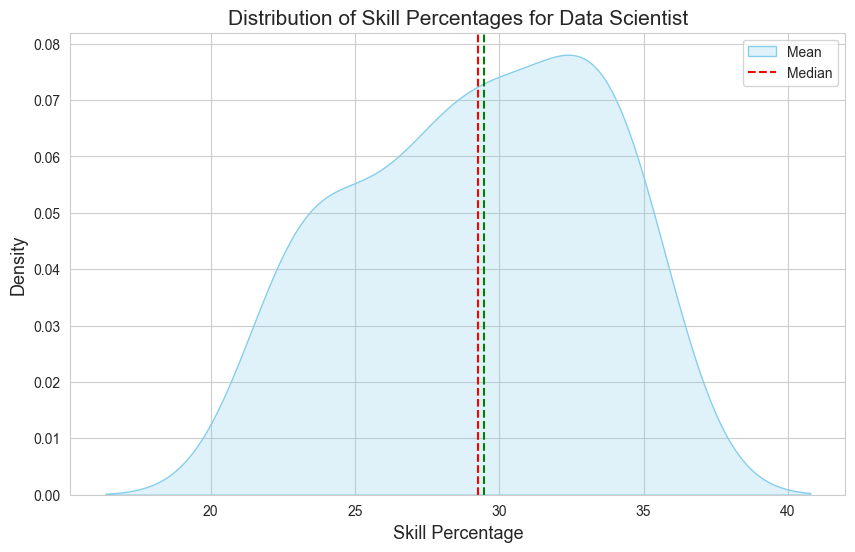

In [294]:
# make distribution plot for Data Scientist
skill_ds_percentages = []

for skill in skills_list:
    skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                     (employee_skills_df[skill]>=3)&
                     (employee_skills_df['Role']=='Data Scientist')])/112*100,2)
    
    if skill_percentage >= (35*0.6):
        # print(skill,': ',f"{skill_percentage}%")
        skill_ds_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_ds_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_ds_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_ds_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])

# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Data Scientist', size=15)
plt.show()

### 2.2.3. Data Engineer Distribution

In [295]:
# Data Engineer
print(f"Total Data Engineer percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Data Engineer'])/len(employee_skills_df)*100}%")
for skill in skills_list:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Data Engineer')])/112*100,2) >= 7:
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Data Engineer')])/112*100,2)}%""")

Total Data Engineer percentage in population: 14.678899082568808%
Mathematics.Linear Algebra :  8.04%
Mathematics.Calculus :  7.14%
Statistics & Probabilities.Statistics :  9.82%
Statistics & Probabilities.Probability & Sampling :  9.82%
Data Structures & Algorithms.Complexity Analysis :  13.39%
Data Structures & Algorithms.Programming :  14.29%
Data Structures & Algorithms.Data Structures :  14.29%
Data Structures & Algorithms.Algorithms :  14.29%
Data Structures & Algorithms.Advanced Algorithms :  11.61%
Data Structures & Algorithms.SQL :  14.29%
Data Structures & Algorithms.Shell / Bash Scripting :  14.29%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  14.29%
Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling :  11.61%
Econometrics, Data Analysis, and Data Visualization.Regression Analysis :  8.93%
Econometrics, Data Analysis, and Data Visualization.Time Series Analysis :  9.82%
Econometrics, Data Analysis, and Data Visualiza

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\2981625244.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_de_percentages, shade=True, color='skyblue')


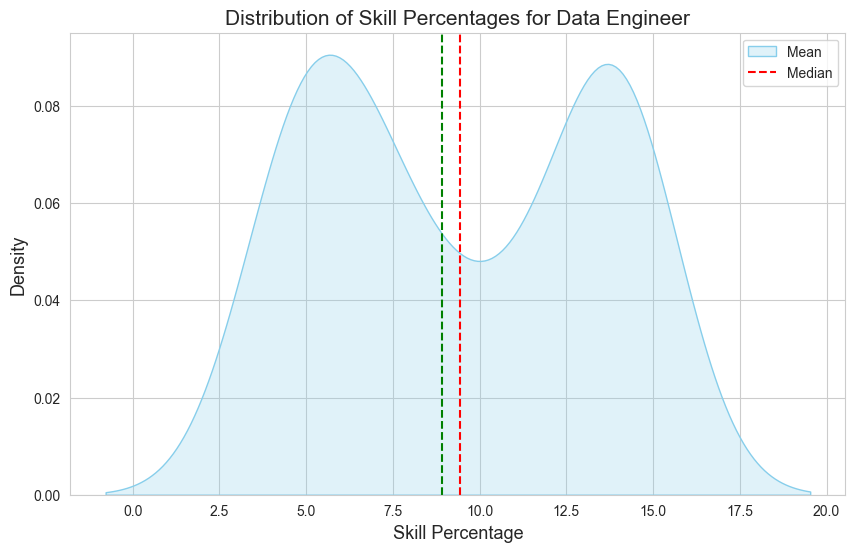

In [296]:
# make distribution plot for Data Engineer
skill_de_percentages = []

for skill in skills_list:
    skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                     (employee_skills_df[skill]>=3)&
                     (employee_skills_df['Role']=='Data Engineer')])/112*100,2)
    
    if skill_percentage >= 4:
        # print(skill,': ',f"{skill_percentage}%")
        skill_de_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_de_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_de_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_de_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])

# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Data Engineer', size=15)
plt.show()

### 2.2.4. Artificial Intelligence Distribution

In [297]:
# AI Engineer
print(f"Total Artificial Intelligence Engineer percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Artificial Intelligence Engineer'])/len(employee_skills_df)*100}%")
for skill in skills_list:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Artificial Intelligence Engineer')])/112*100,2) >= 4:
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Artificial Intelligence Engineer')])/112*100,2)}%""")

Total Artificial Intelligence Engineer percentage in population: 9.174311926605505%
Mathematics.Linear Algebra :  8.93%
Mathematics.Differential Equations :  8.04%
Mathematics.Optimization Technique :  8.93%
Mathematics.Calculus :  8.04%
Mathematics.Combinatorics & Graph :  8.93%
Statistics & Probabilities.Statistics :  8.93%
Statistics & Probabilities.Probability & Sampling :  8.93%
Statistics & Probabilities.Bayessian Method :  6.25%
Statistics & Probabilities.Hypothesis Testing :  5.36%
Statistics & Probabilities.A/B Testing :  7.14%
Statistics & Probabilities.CUPED :  6.25%
Data Structures & Algorithms.Complexity Analysis :  7.14%
Data Structures & Algorithms.Programming :  8.93%
Data Structures & Algorithms.Data Structures :  8.93%
Data Structures & Algorithms.Algorithms :  8.93%
Data Structures & Algorithms.Advanced Algorithms :  8.04%
Data Structures & Algorithms.SQL :  8.93%
Data Structures & Algorithms.Shell / Bash Scripting :  8.93%
Econometrics, Data Analysis, and Data Visua

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\2330573147.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_ai_percentages, shade=True, color='skyblue')


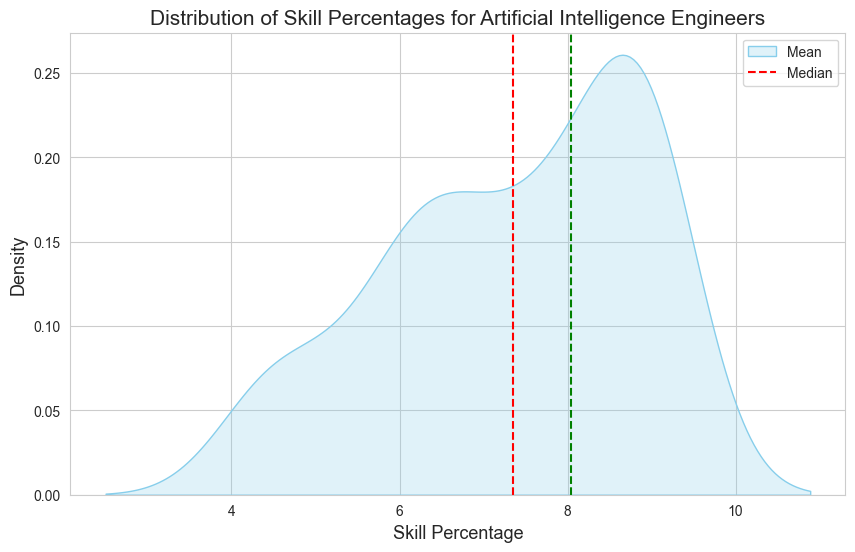

In [298]:
# make distribution plot for Artificial Intelligence
skill_ai_percentages = []

for skill in skills_list:
    skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                     (employee_skills_df[skill]>=3)&
                     (employee_skills_df['Role']=='Artificial Intelligence Engineer')])/112*100,2)
    
    if skill_percentage >= 4:
        # print(skill,': ',f"{skill_percentage}%")
        skill_ai_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_ai_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_ai_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_ai_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])

# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Artificial Intelligence Engineers', size=15)
plt.show()

## 2.3. Employee that Over and Under Qualified by Role



In [299]:
result_moo

employee                                     company  \
0      Talent 1                                      ['P3']   
1      Talent 2                                ['P3', 'P3']   
2      Talent 3                                ['P2', 'P2']   
3      Talent 4                                ['P5', 'P5']   
4      Talent 5                                      ['P4']   
..          ...                                         ...   
104  Talent 107  ['P4', 'P4', 'P4', 'P4', 'P4', 'P4', 'P4']   
105  Talent 108                                ['P4', 'P4']   
106  Talent 109                          ['P2', 'P2', 'P2']   
107  Talent 110  ['P5', 'P5', 'P5', 'P5', 'P5', 'P5', 'P5']   
108  Talent 112                                      ['P2']   

                                         assigned_task  sum_sp  wasted_sp  \
0                                             ['T270']       8         12   
1                                      ['T97', 'T166']      11          9   
2                                     ['T201', 'T297']      11          9   
3                                     ['T153', 'T296']      10         10   
4                                              ['T39']       8         12   
..                                                 ...     ...        ...   
104  ['T20', 'T37', 'T98', 'T124', 'T151', 'T190', ...      11          9   
105                                     ['T81', 'T86']      10         10   
106                             ['T69', 'T91', 'T229']      11          9   
107  ['T42', 'T90', 'T130', 'T143', 'T168', 'T169',...      11          9   
108                                            ['T67']       8         12   

                                      assessment_score  
0                              [-0.027166504381694268]  
1       [-0.017692307692307688, -0.017582417582417582]  
2        [-0.01773854560739807, -0.011648351648351648]  
3        [-0.01749788672865596, -0.011564986737400529]  
4                              [-0.029608127721335267]  
..                                                 ...  
104  [-3.416070845000482e-18, -0.000351648351648352...  
105     [-0.016374269005847958, -0.011263736263736269]  
106  [0.008245349421820009, 0.004321521175453759, 0...  
107  [-0.0016976127320954923, -0.00320082601961797,...  
108                            [-0.031668331668331655]  

[109 rows x 6 columns]

In [307]:
result = {}
for idx, row in result_moo.iterrows():
    employee = row['employee']
    result[employee] = {        
        'company': ast.literal_eval(row['company']),
        'assigned_task': ast.literal_eval(row['assigned_task']),
        'sum_sp': row['sum_sp'],
        'wasted_sp': row['wasted_sp'],
        'assessment_score': ast.literal_eval(row['assessment_score'])
    }

In [308]:
result

{'Talent 1': {'company': ['P3'],
  'assigned_task': ['T270'],
  'sum_sp': 8,
  'wasted_sp': 12,
  'assessment_score': [-0.027166504381694268]},
 'Talent 2': {'company': ['P3', 'P3'],
  'assigned_task': ['T97', 'T166'],
  'sum_sp': 11,
  'wasted_sp': 9,
  'assessment_score': [-0.017692307692307688, -0.017582417582417582]},
 'Talent 3': {'company': ['P2', 'P2'],
  'assigned_task': ['T201', 'T297'],
  'sum_sp': 11,
  'wasted_sp': 9,
  'assessment_score': [-0.01773854560739807, -0.011648351648351648]},
 'Talent 4': {'company': ['P5', 'P5'],
  'assigned_task': ['T153', 'T296'],
  'sum_sp': 10,
  'wasted_sp': 10,
  'assessment_score': [-0.01749788672865596, -0.011564986737400529]},
 'Talent 5': {'company': ['P4'],
  'assigned_task': ['T39'],
  'sum_sp': 8,
  'wasted_sp': 12,
  'assessment_score': [-0.029608127721335267]},
 'Talent 6': {'company': ['P5', 'P5'],
  'assigned_task': ['T83', 'T242'],
  'sum_sp': 11,
  'wasted_sp': 9,
  'assessment_score': [-0.015746606334841626, -0.00968262506724

In [332]:
# Show employee and task in dict that has negative assessment score
for j, val in result.items():    
    if all(scores < 0 for scores in val['assessment_score']):
        for task, score in zip(val['assigned_task'], val['assessment_score']):
        	print(f'{j}: {task} with score = {score}')

Talent 1: T270 with score = -0.027166504381694268
Talent 2: T97 with score = -0.017692307692307688
Talent 2: T166 with score = -0.017582417582417582
Talent 3: T201 with score = -0.01773854560739807
Talent 3: T297 with score = -0.011648351648351648
Talent 4: T153 with score = -0.01749788672865596
Talent 4: T296 with score = -0.011564986737400529
Talent 5: T39 with score = -0.029608127721335267
Talent 6: T83 with score = -0.015746606334841626
Talent 6: T242 with score = -0.00968262506724045
Talent 9: T278 with score = -0.017294429708222814
Talent 9: T289 with score = -0.016429249762583097
Talent 11: T94 with score = -0.007330924109447601
Talent 11: T212 with score = -0.004072398190045248
Talent 11: T253 with score = -0.0009483667017913563
Talent 12: T29 with score = -0.012326803631151458
Talent 12: T36 with score = -0.011317418213969945
Talent 13: T75 with score = -0.004033771106941837
Talent 13: T179 with score = -0.00856748042376785
Talent 14: T10 with score = -0.0038730500268961787
Ta

In [ ]:
# Show the dict sort 

kalo ada employee yg under, bisa fokusin situ sebagai insight apakah skill yang under memang cocok atau tidak sama employeenya, barangkali yg bikin jadi under karna skill ini.
